In [24]:
# Import packages 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy import stats

In [25]:
# FUNCTIONS: 

# define a function that transforms the sample names to coherent condition names
def sample_to_condition(sample: str) -> str:
    """Transform individual sample name to coherent condition name."""
    if sample.startswith('N'):
        return 'normoxia'
    elif sample.startswith('A'):
        return 'anoxia'
    elif sample.startswith('R'):
        return 'reoxygenation'
    else: 
        raise ValueError(f"Unknown sample name {sample}")

# 1 Import DMR and DESeq data 

In [26]:
# read in DMR data (unique gene ids) 
with open('/home/maggy/WholeGenomeBisulphiteSequencing/GO_analysis/1_prepare_data_for_GO_analysis/dmr_unique_geneids.json', 'r') as f:
    dmr_unique_geneids = json.load(f)

# Import DEseq results
# IMPORT raw data 
deg_na = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/RNAseq_pipeline/11_identify_DEG/comp_anoxia_normoxia.csv', header=0, sep=',').assign(condition='Normoxia to Anoxia')
deg_nr = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/RNAseq_pipeline/11_identify_DEG/comp_reoxygenation_normoxia.csv', header=0, sep=',').assign(condition='Normoxia to Reoxygenation')
deg_ar = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/RNAseq_pipeline/11_identify_DEG/comp_anoxia_reoxygenation.csv', header=0, sep=',').assign(condition='Anoxia to Reoxygenation')
deg = pd.concat([deg_na, deg_nr, deg_ar])
deg.rename({'Unnamed: 0': 'geneid'},axis=1,  inplace=True)


# 2 Filter for top 10 genes that were hit by DMR

In [27]:
# Filter deg data to only keep the rows that are in the dmr data (genes that are hit by DMRs)
deg.set_index('geneid', inplace=True)

dmr_genes=[]

for name, df in dmr_unique_geneids.items(): 
    temp = deg[deg.index.isin(df)]
    dmr_genes.append(temp)
dmr_genes = pd.concat(dmr_genes)


In [28]:
# Sort the data by pvalue and keep the top 3 hits for each condition
dmr_genes.sort_values('pvalue', inplace=True)

top_dmr = []

# for each condition filter the top 10 and save in new df 
for condition, data in dmr_genes.groupby('condition'): 
    # filter for unique gene id and keep first 
    temp = data.drop_duplicates(keep='first').iloc[:10]
    top_dmr.append(temp)
top_dmr = pd.concat(top_dmr)



In [29]:
top_dmr

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,condition
geneid,,,,,,,
ccar_ub21-g41935,8242.585025,-0.841461,0.117449,-3.941700,0.000081,0.009505,Anoxia to Reoxygenation
ccar_ua16-g15662,2.945912,-1.819632,1.662382,-0.866901,0.385996,1.000000,Anoxia to Reoxygenation
ccar_ua13-g12491,12.541319,-1.084992,0.836611,-0.844455,0.398415,1.000000,Anoxia to Reoxygenation
ccar_ua16-g15290,1062.446316,-0.524725,0.206984,-0.706400,0.479939,1.000000,Anoxia to Reoxygenation
ccar_ub19-g40403,20.153425,0.668334,0.475908,0.608990,0.542531,1.000000,Anoxia to Reoxygenation
ccar_ua09-g9070,2.555961,-1.229715,1.596788,-0.533072,0.593984,NaN,Anoxia to Reoxygenation
ccar_ua15-g14343,362.651852,0.445586,0.133900,0.500929,0.616421,1.000000,Anoxia to Reoxygenation
ccar_ua11-g11397,4998.455312,-0.240097,0.094415,0.000000,1.000000,1.000000,Anoxia to Reoxygenation
ccar_ub03-g26560,226.252309,0.122420,0.211630,0.000000,1.000000,1.000000,Anoxia to Reoxygenation


# 3 Import feature counts data 

In [30]:
# import fetaure cpounts (gene expression data)
expression = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/RNAseq_pipeline/9_create_GeneCountsMatrix/gene_matrix_count.csv', sep=',', index_col=0)
# reorder the columns of the expression dataframes
# Specify the desired column order
column_order = ['N1', 'N2', 'N3', 'N7', 'A1', 'A2', 'A4', 'A7', 'R2', 'R3', 'R7', 'R8']
# Reorder the dataframe columns
expression = expression.reindex(columns=column_order)

In [31]:
import conorm

# data normlization to get TMM data 
expression_tmm = conorm.tmm(expression)

In [32]:
# filter expression df for all the DMR genes
tmm_dmr = expression_tmm[expression_tmm.index.isin(top_dmr.index)]

In [33]:
tmm_dmr.reset_index(inplace=True)
tmm_dmr.head()

,Geneid,N1,N2,N3,N7,A1,A2,A4,A7,R2,R3,R7,R8
0,ccar_ua02-g1919,240.665021,300.618635,232.147737,228.756122,110.359852,65.547635,103.401341,114.958956,212.590506,136.261056,122.719169,164.802817
1,ccar_ub03-g26528,4938.089690,4607.244704,4357.383884,4359.710428,3625.372722,2718.178495,3872.943292,3715.970565,4863.130287,3986.144313,4481.827805,3999.675552
2,ccar_ub03-g26560,214.914854,327.511037,215.635136,365.056645,190.809091,143.385452,194.517374,157.421273,256.676095,291.842709,259.875887,165.789660
3,ccar_ua05-g5369,780.428134,624.287900,665.360669,626.219884,408.434594,307.254540,409.510261,364.554526,605.442087,406.749420,414.563916,402.632032
4,ccar_ua09-g9070,3.961564,7.683543,0.000000,3.812602,0.000000,0.000000,4.095103,6.213998,3.918719,0.000000,0.000000,1.973686


In [34]:
tmm_dmr = tmm_dmr.melt(id_vars='Geneid', var_name='sample', value_name='measurement')


In [35]:
tmm_dmr['condition'] = tmm_dmr['sample'].apply(sample_to_condition)

In [36]:
tmm_dmr

,Geneid,sample,measurement,condition
0,ccar_ua02-g1919,N1,240.665021,normoxia
1,ccar_ub03-g26528,N1,4938.089690,normoxia
2,ccar_ub03-g26560,N1,214.914854,normoxia
3,ccar_ua05-g5369,N1,780.428134,normoxia
4,ccar_ua09-g9070,N1,3.961564,normoxia
...,...,...,...,...
235,ccar_ua16-g15662,R8,0.000000,reoxygenation
236,ccar_ub19-g40403,R8,12.828962,reoxygenation
237,ccar_ub21-g41935,R8,5589.479972,reoxygenation
238,ccar_ua22-g20613,R8,3731.254197,reoxygenation


# 4 Normalization of data 

In [37]:
grouped = tmm_dmr.groupby(['Geneid'])

tmm_norm = []

for gene_id, data in grouped: 
    # calculate the mean for normoxia
    mean = data.loc[data.condition == 'normoxia', 'measurement']
    if len(mean) == 0: 
        continue
    mean = mean.mean() 
    # calculate the geomean in normoxia 
    geomean = stats.gmean(data.loc[data.condition == 'normoxia', 'measurement'])
    # write the calculated mean into a new column
    data["norm_average"] = mean
    # Determination of relative deviation
    data["rel_deviation"] = data["measurement"]/mean
    tmm_norm.append(data)
tmm_norm = pd.concat(tmm_norm)

In [38]:
tmm_norm

,Geneid,sample,measurement,condition,norm_average,rel_deviation
0,ccar_ua02-g1919,N1,240.665021,normoxia,250.546879,0.960559
20,ccar_ua02-g1919,N2,300.618635,normoxia,250.546879,1.199850
40,ccar_ua02-g1919,N3,232.147737,normoxia,250.546879,0.926564
60,ccar_ua02-g1919,N7,228.756122,normoxia,250.546879,0.913027
80,ccar_ua02-g1919,A1,110.359852,anoxia,250.546879,0.440476
...,...,...,...,...,...,...
157,ccar_ub21-g41935,A7,8356.791107,anoxia,6881.281212,1.214424
177,ccar_ub21-g41935,R2,8676.043881,reoxygenation,6881.281212,1.260818
197,ccar_ub21-g41935,R3,7134.384822,reoxygenation,6881.281212,1.036781
217,ccar_ub21-g41935,R7,7923.120807,reoxygenation,6881.281212,1.151402


# 5 Significance test

First we have to test if there is an overall significance between the samples 

In [39]:
from scipy.stats import f_oneway
from scipy.stats import alexandergovern

# test if expression changes are significant 
def stats_test(data: pd.DataFrame):
    grouped = data.groupby('Geneid')
    anova_results = pd.DataFrame(columns=['F', 'p'])
    for geneid, data in grouped: 
        if data['rel_deviation'].isna().all(): 
            continue
        samples=[]
        std_dev=[]
        for _, sample in data.groupby('condition'):
            samples.append(sample['rel_deviation'])
            std_dev.append(sample['rel_deviation'].std())
        if np.all(np.isclose(std_dev, np.mean(std_dev), rtol=0.5)):
            test='anova'
            res = f_oneway(*samples)
        else:
            test= 'alexander-govern'
            res = alexandergovern(*samples)
        F,p = res.statistic, res.pvalue
        anova_results.loc[geneid, 'F'] = F
        anova_results.loc[geneid, 'p'] = p
        anova_results.loc[geneid, 'Test'] = test
    return anova_results

In [40]:
# apply the defines significance test onto the dataframe 
stat_res = stats_test(tmm_norm)


In [41]:
stat_res

,F,p,Test
ccar_ua02-g1919,21.775006,0.000356,anova
ccar_ua05-g5369,16.604959,0.000954,anova
ccar_ua09-g9070,0.748234,0.500492,anova
ccar_ua11-g11397,2.374983,0.304985,alexander-govern
ccar_ua13-g12491,0.583818,0.577566,anova
ccar_ua14-g13591,5.995003,0.022133,anova
ccar_ua15-g14340,2.27812,0.158294,anova
ccar_ua15-g14343,12.685668,0.001759,alexander-govern
ccar_ua15-g14373,17.35844,0.00017,alexander-govern
ccar_ua15-g14605,7.534196,0.023119,alexander-govern


Now we have established that we have an overall significance, hence we must perform a posthoc test

In [42]:
from scipy.stats import tukey_hsd
from scipy.stats import mannwhitneyu

# perform post-hoc test 
def posthoc_test(data: pd.DataFrame): 
    grouped = data.groupby('Geneid')
    posthoc_results = pd.DataFrame(index=data['Geneid'].unique())
    for geneid, data in grouped: 
        if data['rel_deviation'].isna().all(): 
            continue
        samples=[]
        groups = list(data.groupby('condition').groups.keys())
        names = []
        for i in groups: 
            for j in groups: 
                names.append('p ' + i+j)
        for name, sample in data.groupby(['condition']):
            samples.append(sample['rel_deviation'])
        test = 'tukey_hsd'
        res = tukey_hsd(*samples)
        posthoc_results.loc[geneid,names] = res.pvalue.flatten()
    return posthoc_results


In [43]:
post_res = posthoc_test(tmm_norm)
post_res

,p anoxiaanoxia,p anoxianormoxia,p anoxiareoxygenation,p normoxiaanoxia,p normoxianormoxia,p normoxiareoxygenation,p reoxygenationanoxia,p reoxygenationnormoxia,p reoxygenationreoxygenation
ccar_ua02-g1919,1.0,0.000276,0.066363,0.000276,1.0,0.008542,0.066363,0.008542,1.0
ccar_ua05-g5369,1.0,0.000886,0.305312,0.000886,1.0,0.007692,0.305312,0.007692,1.0
ccar_ua09-g9070,1.0,0.792771,0.841903,0.792771,1.0,0.470495,0.841903,0.470495,1.0
ccar_ua11-g11397,1.0,0.283480,0.707559,0.283480,1.0,0.700503,0.707559,0.700503,1.0
ccar_ua13-g12491,1.0,0.912084,0.791469,0.912084,1.0,0.554193,0.791469,0.554193,1.0
ccar_ua14-g13591,1.0,0.284601,0.213008,0.284601,1.0,0.017722,0.213008,0.017722,1.0
ccar_ua15-g14340,1.0,0.174315,0.956797,0.174315,1.0,0.260683,0.956797,0.260683,1.0
ccar_ua15-g14343,1.0,0.018389,0.003915,0.018389,1.0,0.569040,0.003915,0.569040,1.0
ccar_ua15-g14373,1.0,0.000577,0.025453,0.000577,1.0,0.057169,0.025453,0.057169,1.0
ccar_ua15-g14605,1.0,0.005729,0.405169,0.005729,1.0,0.044519,0.405169,0.044519,1.0


In [44]:
post_res.drop(columns=['p anoxiaanoxia', 'p reoxygenationreoxygenation', 'p normoxianormoxia', 'p anoxianormoxia', 'p reoxygenationnormoxia', 'p reoxygenationnormoxia', 'p reoxygenationanoxia'], inplace=True)

In [45]:
post_res

,p anoxiareoxygenation,p normoxiaanoxia,p normoxiareoxygenation
ccar_ua02-g1919,0.066363,0.000276,0.008542
ccar_ua05-g5369,0.305312,0.000886,0.007692
ccar_ua09-g9070,0.841903,0.792771,0.470495
ccar_ua11-g11397,0.707559,0.283480,0.700503
ccar_ua13-g12491,0.791469,0.912084,0.554193
ccar_ua14-g13591,0.213008,0.284601,0.017722
ccar_ua15-g14340,0.956797,0.174315,0.260683
ccar_ua15-g14343,0.003915,0.018389,0.569040
ccar_ua15-g14373,0.025453,0.000577,0.057169
ccar_ua15-g14605,0.405169,0.005729,0.044519


# 5 PLOT (Barplot)

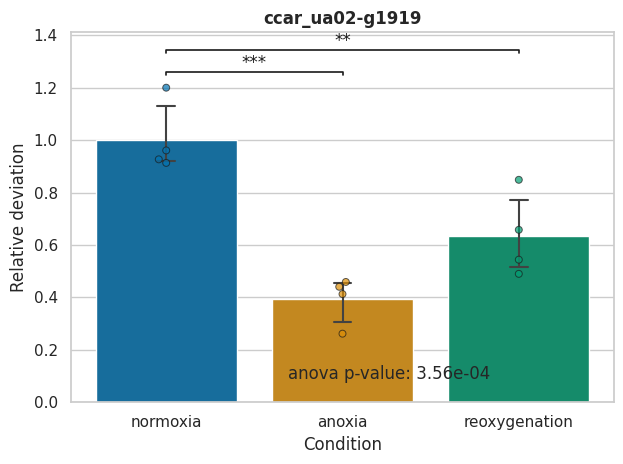

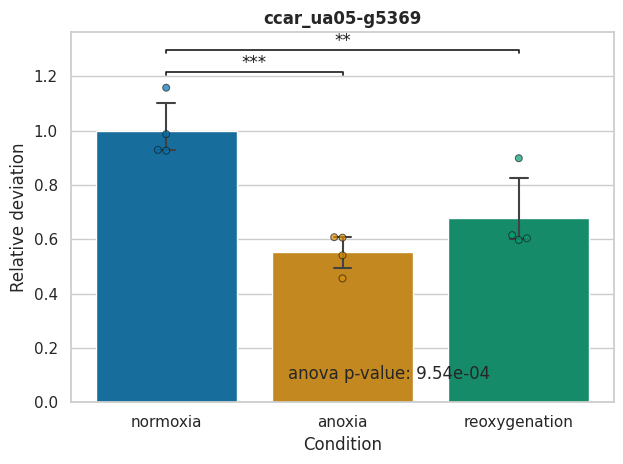

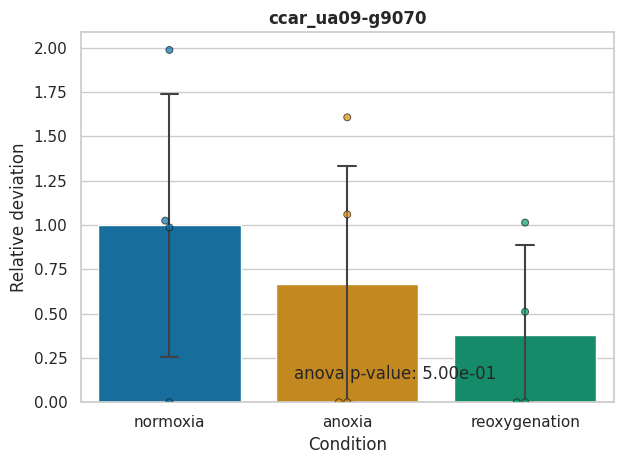

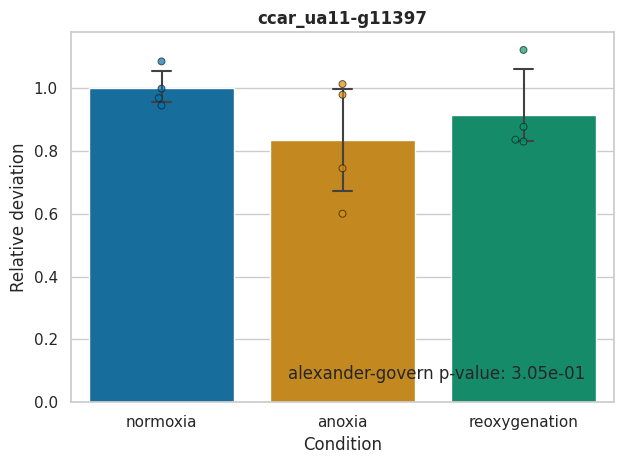

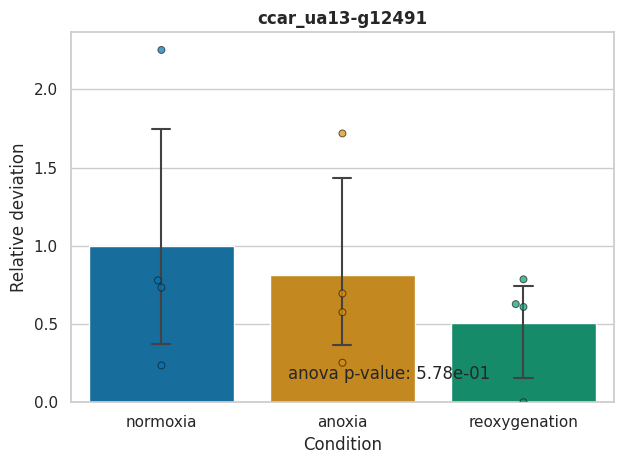

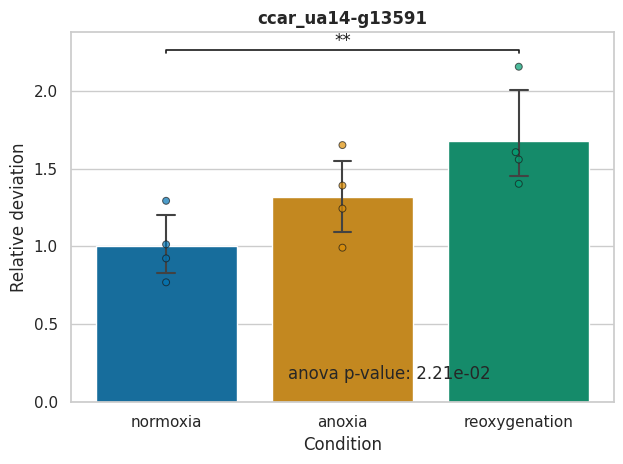

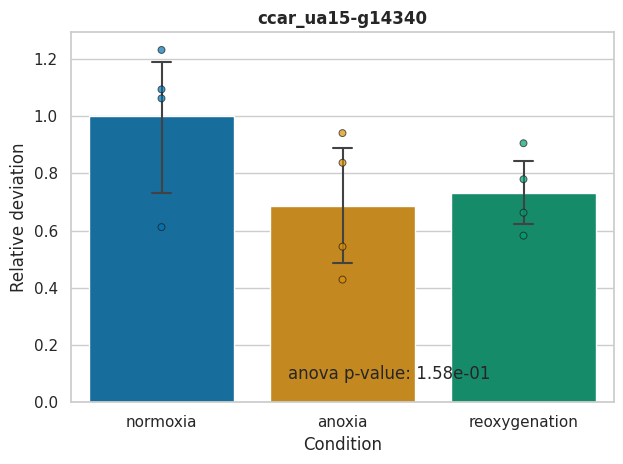

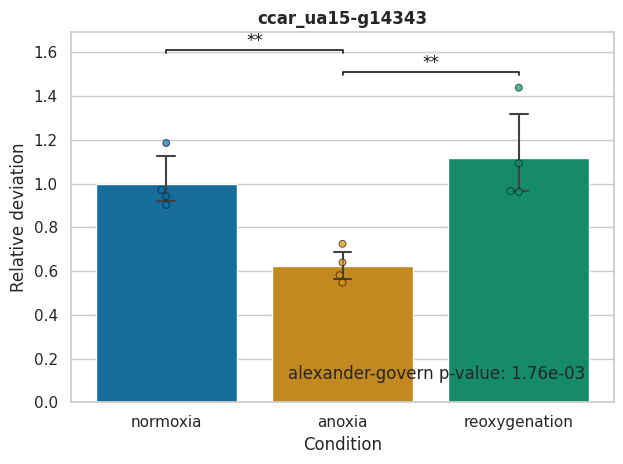

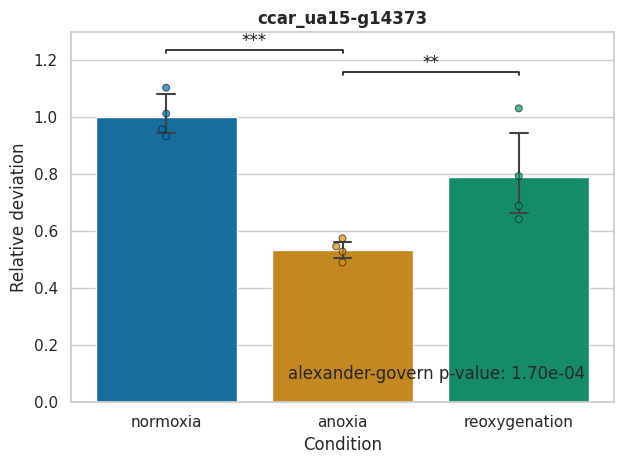

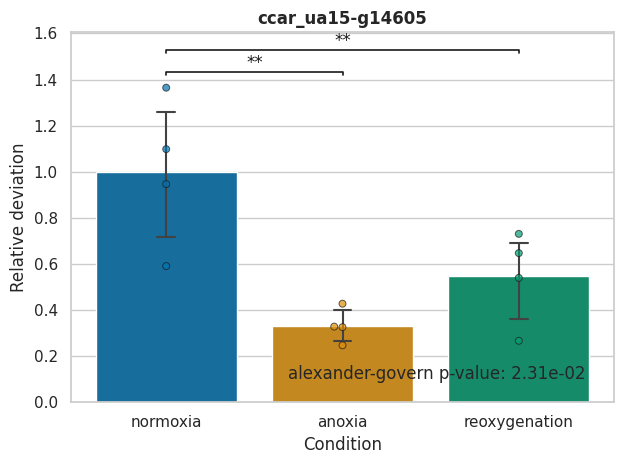

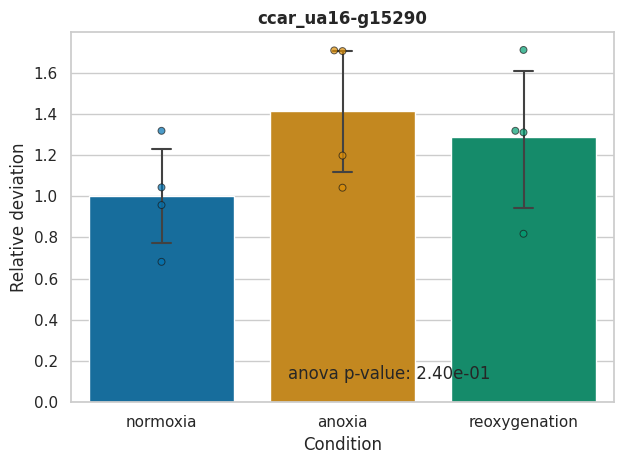

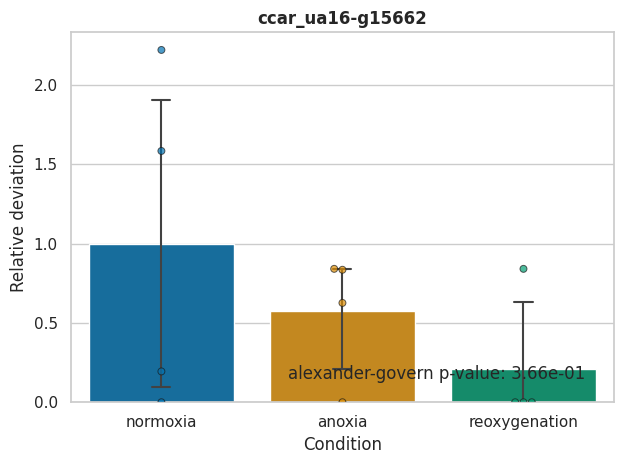

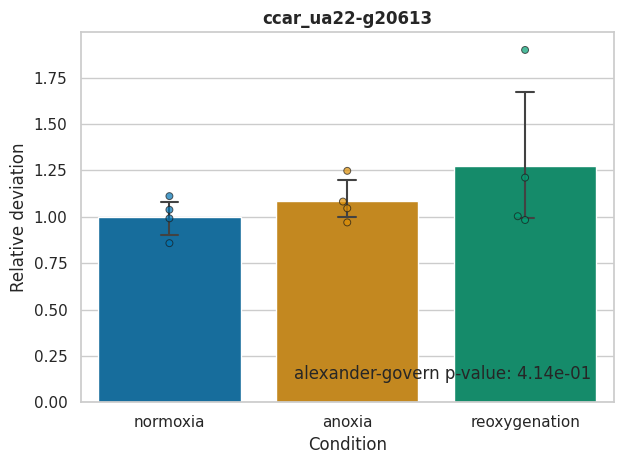

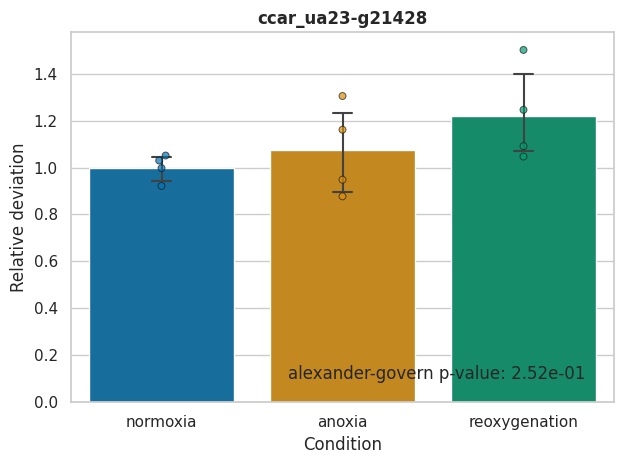

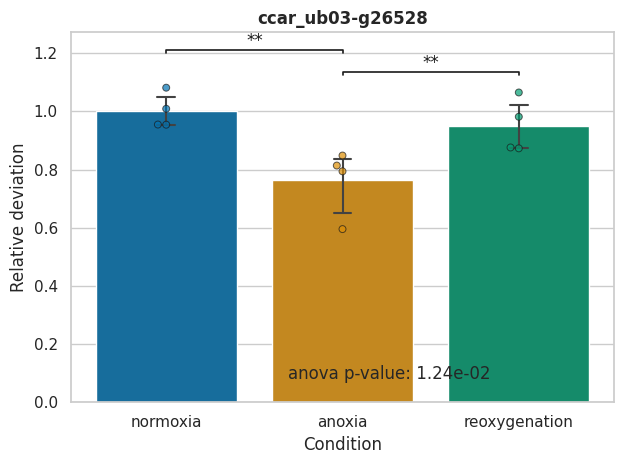

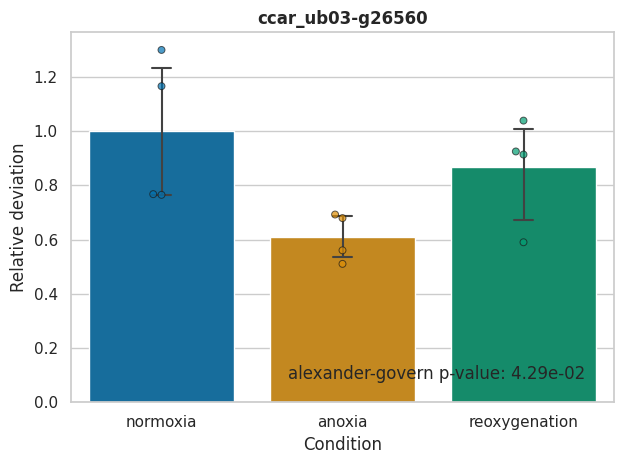

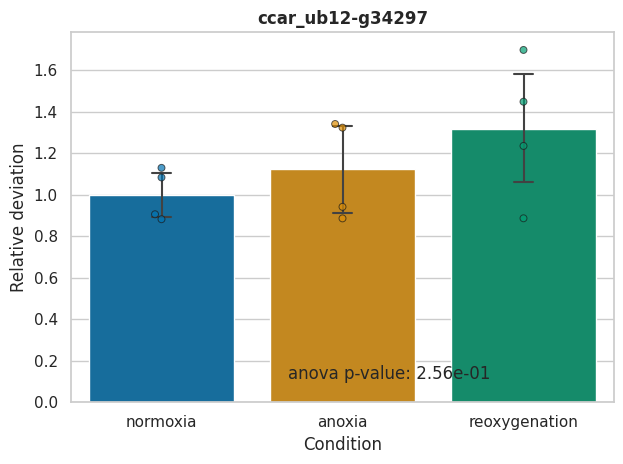

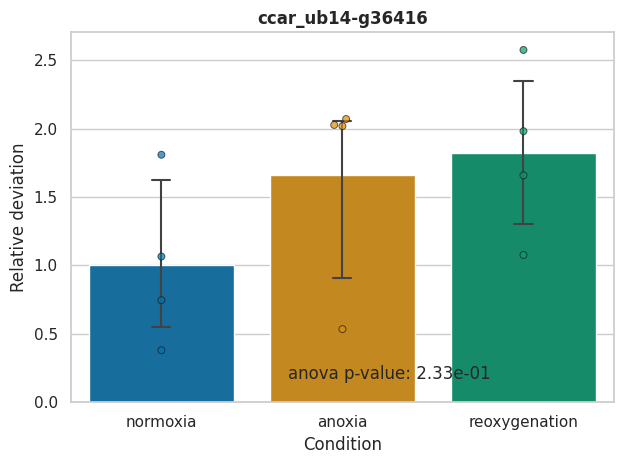

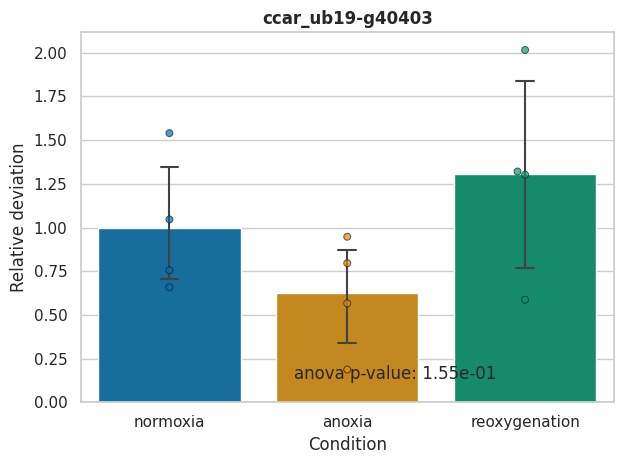

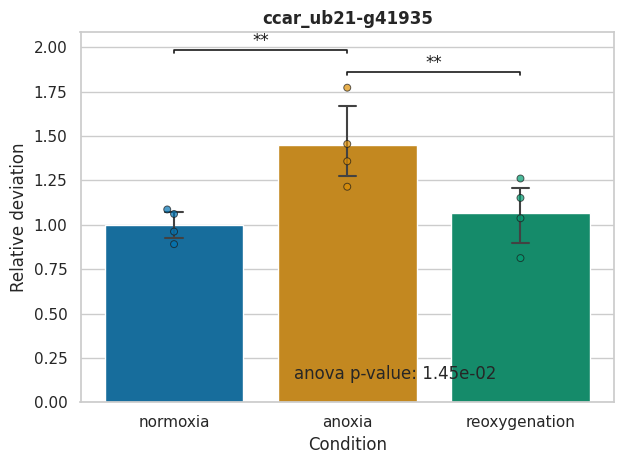

In [46]:
# define sig list 
sig_list = {'p anoxiareoxygenation': (1,2),
            'p normoxiaanoxia': (0,1),
            'p normoxiareoxygenation': (0,2)}

def sig_cat(s):
    if s < 0.0027:
        return "***"
    if s < 0.0455:
        return "**"
    
# set sns colorpallete to colorblind 
sns.set_theme(palette='colorblind', style='whitegrid')

for geneid, data in tmm_norm.groupby('Geneid'): 
    #if stat_res.loc[geneid, 'p'] > 0.05: # skip gened that are not sig in the anova test 
    #    continue
    if np.any(stat_res.loc[geneid, 'Test'] == ''):
        continue

    # PLOT
    g = sns.barplot(data=data, x='condition', y='rel_deviation', capsize=0.1, err_kws={"linewidth": 1.5}, hue='condition', legend=False)
    sns.swarmplot(data=data, x='condition', y='rel_deviation', palette='colorblind', size=5, ax=g, 
                  dodge=False, legend=False, linewidth=0.7, edgecolor="k", alpha=0.7, hue='condition')
    plt.title(geneid, fontdict={'weight': 'bold'})
    plt.ylabel('Relative deviation')
    plt.xlabel('Condition')
    # significance bars 
    x_pos = np.array([p.get_x() for p in g.patches])
    x_width = np.array([p.get_width() for p in g.patches])
    x_pos = x_pos + (x_width/2)
    y, h, col = data['rel_deviation'].max() * 1.04, data['rel_deviation'].max() * 0.01, 'k'

    offset=0
    sig_info = post_res.loc[geneid, sig_list.keys()]
    sig_info = sig_info.loc[sig_info <= 0.05]
    for name, value in sig_info.items():
        height= np.array([y, y+h, y+h, y]) + offset
        x1, x2 = x_pos[list(sig_list[name])]
        plt.plot([x1, x1, x2, x2], height, lw=1.2, c=col)
        plt.text((x1+x2)*.5, y+h+offset, sig_cat(value), ha='center', va='bottom', color=col)
        offset += data['rel_deviation'].max() * 0.07
    plt.text(0.4, 0.1, f"{stat_res.loc[geneid, 'Test']} p-value: {stat_res.loc[geneid, 'p']:.2e}", ha='left', va='top', transform=g.transAxes)
    plt.tight_layout()
    plt.show()
    plt.savefig(f"12_TMM_plot/{geneid}_TMM_crucian_carp_data_normalized.png")
    plt.close()
    




